# TASK 2 - WORD VECTORS EVALUATION

*by Lucía De Pineda & Aina Luis*

### Imports

In [1]:
import numpy as np
import pickle
import torch

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [9.5, 6]

In [2]:
from types import SimpleNamespace
from collections import Counter
import os
import re
import pathlib
import subprocess
import array
import pickle
import numpy as np
import pandas as pd

In [3]:
from sklearn.decomposition import PCA
from nltk.cluster import KMeansClusterer
import nltk

### Definition of the classes

In [4]:
class Vocabulary(object):
    def __init__(self, pad_token='<pad>', unk_token='<unk>', eos_token='<eos>'):
        self.token2idx = {}
        self.idx2token = []
        self.pad_token = pad_token
        self.unk_token = unk_token
        self.eos_token = eos_token
        if pad_token is not None:
            self.pad_index = self.add_token(pad_token)
        if unk_token is not None:
            self.unk_index = self.add_token(unk_token)
        if eos_token is not None:
            self.eos_index = self.add_token(eos_token)

    def add_token(self, token):
        if token not in self.token2idx:
            self.idx2token.append(token)
            self.token2idx[token] = len(self.idx2token) - 1
        return self.token2idx[token]

    def get_index(self, token):
        if isinstance(token, str):
            return self.token2idx.get(token, self.unk_index)
        else:
            return [self.token2idx.get(t, self.unk_index) for t in token]

    def get_token(self, index):
        return self.idx2token[index]

    def __len__(self):
        return len(self.idx2token)

    def save(self, filename):
        with open(filename, 'wb') as f:
            pickle.dump(self.__dict__, f)

    def load(self, filename):
        with open(filename, 'rb') as f:
            self.__dict__.update(pickle.load(f))

In [5]:
class Punctuation:
    html = re.compile(r'&apos;|&quot;')
    punctuation = re.compile(r'[^\w\s·]|_')
    spaces = re.compile(r'\s+')
    ela_geminada = re.compile(r'l · l')

    def strip(self, s):
        '''
        Remove all punctuation characters.
        '''
        s = self.html.sub(' ', s)
        s = self.punctuation.sub(' ', s)
        s = self.spaces.sub(' ', s).strip()
        s = self.ela_geminada.sub('l·l', s)
        return s

In [6]:
def remove_punctuation(input_path, output_path):
    punc = Punctuation()
    with open(input_path, 'r', encoding='utf-8') as inpf, open(output_path, 'w', encoding='utf-8') as outf:
        for line in inpf:
            line = punc.strip(line)
            print(line, file=outf)

In [7]:
class WordVectors:
    def __init__(self, vectors, vocabulary): 
        self.vectors = vectors
        self.voc_size = len(vocabulary)
        self.vocabulary = vocabulary
    
    def cosine_similarity(self, vec1, vec2):
        sum_sim = 0
        norm_vec1 = 0
        norm_vec2 = 0
        if len(vec1) != len(vec2):
            print('ERROR: Wrong representation')
            return
        else:        
            for pos in range(len(vec1)):
                sum_sim += vec1[pos]*vec2[pos]
                norm_vec1 += vec1[pos]*vec1[pos]
                norm_vec2 += vec2[pos]*vec2[pos]
            if norm_vec1 != 0 and norm_vec2 != 0:
                return sum_sim/(np.sqrt(norm_vec1)*np.sqrt(norm_vec2))
            else: 
                return 0
    
    def operation(self, vec1, vec2, op):
        vec_diff = []
        if len(vec1) != len(vec2):
            print('ERROR: Wrong representation')
            return
        else:  
            for pos in range(len(vec1)):
                if op == 'sum':
                    vec_diff.append(vec1[pos]+vec2[pos])
                elif op == 'sub':
                    vec_diff.append(vec1[pos]-vec2[pos])
            return vec_diff
        
    def most_similar(self, word, topn=10):
        word_id = self.vocabulary.get_index(word)
        sim_word = []
        for w2_id in range (self.voc_size):
            if w2_id != word_id:
                sim_word.append((self.vocabulary.get_token(w2_id), self.cosine_similarity(self.vectors[word_id], self.vectors[w2_id])))
        sim_word.sort(key = lambda x: -x[1])
        return sim_word[0:topn]
    
    def analogy(self, x1, x2, y1, topn=5, keep_all=False):
        # If keep_all is False we remove the input words (x1, x2, y1) from the returned closed words
        x1_id = self.vocabulary.get_index(x1)
        x2_id = self.vocabulary.get_index(x2)
        y1_id = self.vocabulary.get_index(y1)
        vec_x1 = self.vectors[x1_id]
        vec_x2 = self.vectors[x2_id]
        vec_y1 = self.vectors[y1_id]
        dif_vec = self.operation(vec_x2, vec_x1, 'sub')
        vec_ref = self.operation(dif_vec, vec_y1, 'sum')
        analogy_word = []
        for y2_id in range (self.voc_size):
            if keep_all or (y2_id!=x1_id and y2_id!=x2_id and y2_id!=y1_id):
                vec_y2 = self.vectors[y2_id]
                analogy_word.append((self.vocabulary.get_token(y2_id), self.cosine_similarity(vec_ref, vec_y2)))
        analogy_word.sort(key = lambda x: -x[1])
        return analogy_word[0:topn]

### Uploading of the vocabulary and generation of the models 

We will use the vocabulary computed by the Text Preprocessing notebook (text-preprocessing), and the word vectors computed by the CBOW Model C notebook (cbow-vectors).

In [8]:
DATASET_VERSION = 'ca-100'
CBOW_VOCABULARY_ROOT = f'../input/text-preprocessing/data/{DATASET_VERSION}'
CBOW_VECTORS_ROOT = f'../input/apartado-c/data/{DATASET_VERSION}'

In [9]:
dict = f'{CBOW_VOCABULARY_ROOT}/ca.wiki.train.tokens.nopunct.dic'
counter = pickle.load(open(dict, 'rb'))
words, values = zip(*counter.most_common(5000))
print('Most frequent Catalan words')
print(words[:10])
print(values[:10])

Most frequent Catalan words
('de', 'la', 'i', 'a', 'el', 'd', 'l', 'que', 'en', 'va')
(5029788, 2771563, 2495802, 2130330, 1704858, 1362665, 1322822, 1293716, 1266356, 1191615)


In [10]:
from scipy.stats import entropy
h = entropy(values)
print(f'Word entropy: {h:5.2f}, Perplexity: {np.exp(h):5.0f}')
print(f'Probability of the most frequent word: {values[0]/sum(values):2.3f}')

Word entropy:  6.22, Perplexity:   505
Probability of the most frequent word: 0.076


**Zipf's law of words**. Zipf's law was originally formulated in terms of quantitative linguistics, stating that given some corpus of natural language utterances, the frequency of any word is inversely proportional to its rank in the frequency table.

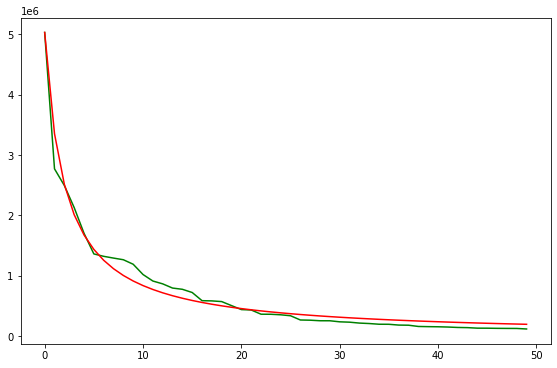

In [11]:
_ = plt.plot(values[:50], 'g', 2*values[0]/np.arange(2,52), 'r')

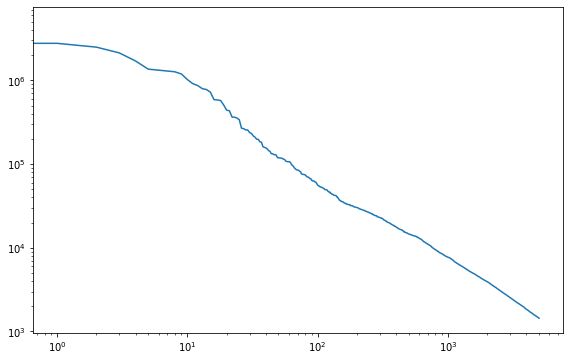

In [12]:
_ = plt.loglog(values)
plt.show()

**Benford's law**, also called the Newcomb–Benford law, the law of anomalous numbers, or the first-digit law, is an observation about the frequency distribution of leading digits in many real-life sets of numerical data.

Counter({1: 1705, 2: 1332, 3: 673, 4: 450, 5: 283, 6: 192, 7: 157, 8: 126, 9: 82})


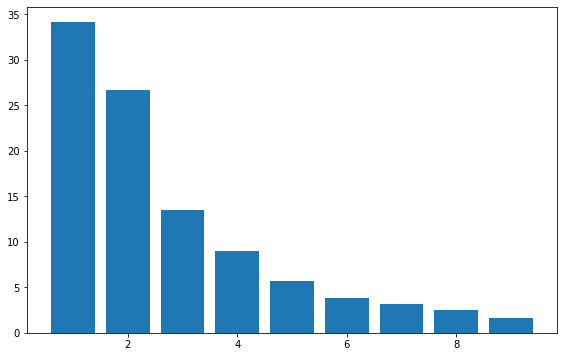

In [13]:
from collections import Counter
benford = Counter(int(str(item[1])[0]) for item in counter.most_common(5000))
print(benford)
percentage = np.array(list(benford.values()), dtype=float)
percentage /= percentage.sum()
_ = plt.bar(list(benford.keys()), percentage*100)

In [14]:
modelname = f'{CBOW_VECTORS_ROOT}/{DATASET_VERSION}.pt'
state_dict = torch.load(modelname, map_location=torch.device('cpu'))

In [15]:
input_word_vectors = state_dict['emb.weight'].numpy()
output_word_vectors = state_dict['lin.weight'].numpy()

In [16]:
token_vocab = Vocabulary()
token_vocab.load(f'{CBOW_VOCABULARY_ROOT}/ca.wiki.vocab')

In [17]:
model1 = WordVectors(input_word_vectors, token_vocab)
model2 = WordVectors(output_word_vectors, token_vocab)

### Looking for most similar words

In [18]:
model1.most_similar('català')

[('valencià', 0.8966472396059136),
 ('basc', 0.8486368720995038),
 ('gallec', 0.7824255608434053),
 ('mallorquí', 0.7668336708113344),
 ('castellà', 0.7572442597077931),
 ('navarrès', 0.7497890396655548),
 ('neerlandès', 0.74571373689574),
 ('romanès', 0.7264740421184357),
 ('portuguès', 0.7232562143235629),
 ('francès', 0.716595942189798)]

In [19]:
model1.most_similar('casa')

[('finca', 0.7651913984842528),
 ('masia', 0.7227804951501101),
 ('barraca', 0.6704054216869894),
 ('mansió', 0.6560298009694184),
 ('cabana', 0.652651306609716),
 ('vila', 0.6361850991600445),
 ('fortalesa', 0.632124247625034),
 ('granja', 0.6304387468090924),
 ('habitació', 0.6252301433236155),
 ('bassa', 0.6176714598467475)]

In [20]:
model1.most_similar('banc')

[('buc', 0.670424478907233),
 ('moll', 0.6641065722338934),
 ('tanc', 0.655862803217196),
 ('corredor', 0.6552406056554092),
 ('zoo', 0.6444781640060616),
 ('balcó', 0.6317966565028333),
 ('pilar', 0.6237683825823723),
 ('proveïdor', 0.6228871008463195),
 ('repositori', 0.6187815502583963),
 ('comboi', 0.6186514027028645)]

In [21]:
model2.most_similar('català')

[('francès', 0.9044073668905137),
 ('anglès', 0.8977542690649529),
 ('espanyol', 0.8971587870220512),
 ('alemany', 0.8933394091887107),
 ('castellà', 0.8753904387013661),
 ('italià', 0.860145427650086),
 ('rus', 0.8584630980767858),
 ('portuguès', 0.8581308732281967),
 ('grec', 0.8405046862569099),
 ('japonès', 0.8366606356073163)]

In [22]:
model2.most_similar('casa')

[('Roma', 0.8512310563115476),
 ('ciutat', 0.8459281768182569),
 ('propietat', 0.8358765003548796),
 ('dona', 0.8340125656262013),
 ('Rússia', 0.8230945573975121),
 ('obra', 0.8230021052615292),
 ('mare', 0.8186887936434977),
 ('música', 0.8186223623474785),
 ('París', 0.8186149633308097),
 ('capital', 0.8138500751282594)]

In [23]:
model2.most_similar('banc')

[('corredor', 0.9174292408547489),
 ('bloc', 0.9044860993928407),
 ('desert', 0.9006056210003588),
 ('tribunal', 0.9005192048737988),
 ('magatzem', 0.8987332491977925),
 ('volant', 0.8974297705365679),
 ('moll', 0.8952906553017266),
 ('forn', 0.894895391369246),
 ('museu', 0.8945814814867218),
 ('client', 0.8937923985323746)]

### Looking for analogies

In [24]:
model1.analogy('França', 'francès', 'Polònia')

[('polonès', 0.7302620427345439),
 ('rus', 0.7294077928728961),
 ('suec', 0.7001087547228407),
 ('romanès', 0.6946904401115087),
 ('alemany', 0.6920949504835143)]

In [25]:
model1.analogy('un', 'dos', 'tres')

[('cinc', 0.7621840906492645),
 ('quatre', 0.7490343912650385),
 ('sis', 0.7413847423712532),
 ('vuit', 0.73054059664786),
 ('dotze', 0.7211573624048647)]

In [26]:
model1.analogy('dilluns', 'dimarts', 'dimecres')

[('dijous', 0.6019801514300591),
 ('divendres', 0.5973331932611301),
 ('dissabte', 0.5374500547453094),
 ('dissabtes', 0.46155273729181684),
 ('dia', 0.45135969716670593)]

In [27]:
model2.analogy('França', 'francès', 'Polònia')

[('polonès', 0.9190087000477082),
 ('rus', 0.9039990033813486),
 ('suec', 0.8966731891423321),
 ('romanès', 0.8924005179177729),
 ('basc', 0.8923971170800707)]

In [28]:
model2.analogy('un', 'dos', 'tres')

[('dues', 0.8936959905472144),
 ('quatre', 0.889503843418989),
 ('set', 0.8464327196388995),
 ('4', 0.8413765528566006),
 ('10', 0.8401214338331634)]

In [29]:
model2.analogy('dilluns', 'dimarts', 'dimecres')

[('divendres', 0.9539057830883041),
 ('dijous', 0.952255944278861),
 ('dissabte', 0.9471096614130475),
 ('dissabtes', 0.9386328357351887),
 ('diumenges', 0.932970226481075)]

### Visualization of an analogy

In [30]:
analogies_pca = []
analogies_pca.append(model1.vectors[model1.vocabulary.get_index('dos')])
analogies_pca.append(model1.vectors[model1.vocabulary.get_index('2')])
analogies_pca.append(model1.vectors[model1.vocabulary.get_index('tres')])
analogies_pca.append(model1.vectors[model1.vocabulary.get_index('3')])
analogies_pca.append(model1.vectors[model1.vocabulary.get_index('quatre')])
analogies_pca.append(model1.vectors[model1.vocabulary.get_index('4')])
analogies_pca.append(model1.vectors[model1.vocabulary.get_index('cinc')])
analogies_pca.append(model1.vectors[model1.vocabulary.get_index('5')])
words = ['dos','2','tres','3','quatre','4','cinc','5']

In [31]:
pca = PCA(n_components=2)
word_vectors = pca.fit_transform(analogies_pca)

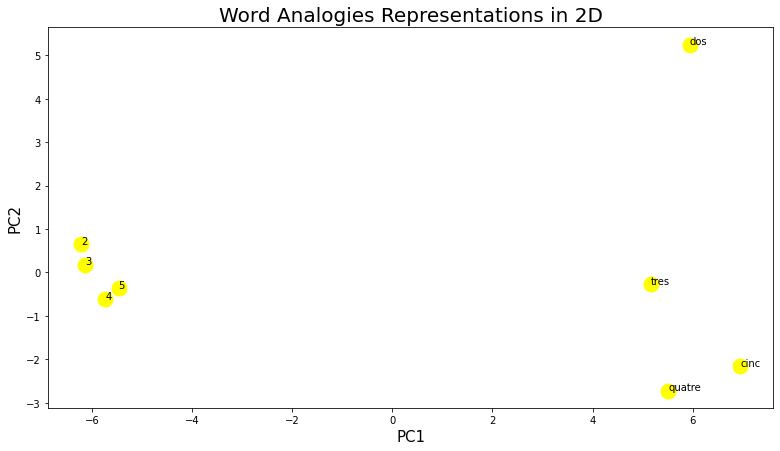

In [32]:
plt.figure(figsize=(13,7))
plt.scatter(word_vectors[:,0],word_vectors[:,1],linewidths=10,color='yellow')
plt.xlabel("PC1",size=15)
plt.ylabel("PC2",size=15)
plt.title("Word Analogies Representations in 2D",size=20)
for i, word in enumerate(words):
    plt.annotate(word,xy=(word_vectors[i,0],word_vectors[i,1]))

### Visualization of words cluster

We have selected the content of the Wikipedia page that explains the fable of *The Three Little Pigs* with the aim of just representing in 2D the words that are present in this fragment.

In [33]:
# Read the text and do the preprocess
remove_punctuation(f'../input/example/text.txt', f'../text_correct.txt')

In [34]:
# Obtain the list of words and its corresponding embeddings
word_embedding = []
words=[]
with open(f'../text_correct.txt', 'r', encoding='utf-8') as inpf:
    for line in inpf:
        line = line.split()
        for word in line:
            try:
                words.append(word)
                word_embedding.append(model1.vectors[model1.vocabulary.get_index(word)])
            except:
                pass

In [35]:
# Do the PCA decomposition
pca = PCA(n_components=2)
word_vectors = pca.fit_transform(word_embedding)

# Do the clustering
NUM_CLUSTERS=4
kclusterer = KMeansClusterer(NUM_CLUSTERS, distance=nltk.cluster.util.cosine_distance, repeats=25, avoid_empty_clusters=True)
assigned_clusters = kclusterer.cluster(word_embedding, assign_clusters=True)

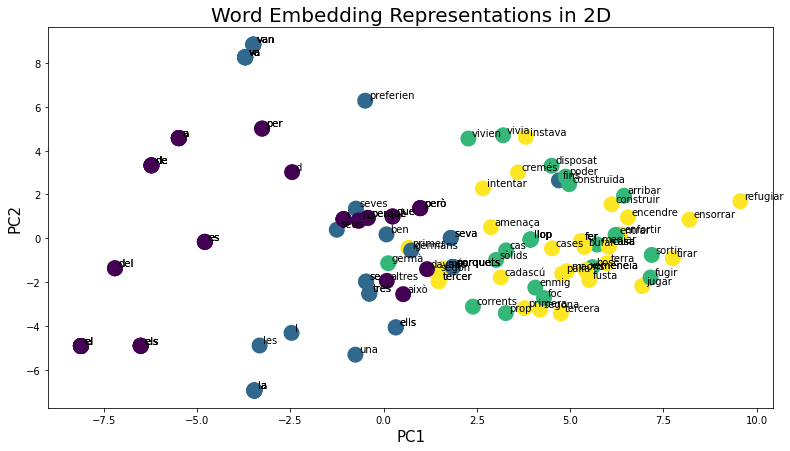

In [36]:
# Do the visualization
plt.figure(figsize=(13,7))
plt.scatter(word_vectors[:,0],word_vectors[:,1],linewidths=10,c=assigned_clusters)
plt.xlabel("PC1",size=15)
plt.ylabel("PC2",size=15)
plt.title("Word Embedding Representations in 2D",size=20)
for i, word in enumerate(words):
    plt.annotate(word,xy=(word_vectors[i,0]+0.1,word_vectors[i,1]+0.1))
plt.savefig(f'../working/visualization.png')